In [1]:
import matplotlib.pyplot as plt
from tensorflow import keras
from imutils import paths
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression

In [17]:
# train = pd.read_csv('train.csv',usecols=[1])
train = pd.read_csv('train.csv',header=None)
test = pd.read_csv('test.csv',header=None)

In [18]:
train=train[(train!=0).all(1)]
test=test[(test!=0).all(1)]

In [20]:
train_x=train.drop(train.columns[500],axis=1).copy()
train_y=train.drop(train.columns[0:500],axis=1).copy()
test_x=test.drop(test.columns[500],axis=1).copy()
test_y=test.drop(test.columns[0:500],axis=1).copy()

In [21]:
train_x=train_x.to_numpy()
test_x=test_x.to_numpy()



train_x=train_x.reshape(-1,1)
test_x=test_x.reshape(-1,1)

In [22]:
# train_x=resample(train_x, replace=True, n_samples=492785, random_state=None, stratify=None)
# test_x=resample(test_x, replace=True, n_samples=290970, random_state=None, stratify=None)


In [23]:
Xscaler = MinMaxScaler(feature_range=(0, 1)) # scale so that all the X data will range from 0 to 1
Xscaler.fit(train_x)
scaled_X_train = Xscaler.transform(train_x)

Yscaler = MinMaxScaler(feature_range=(0, 1))
Yscaler.fit(train_y)
scaled_y_train = Yscaler.transform(train_y)






scaled_X_test = Xscaler.transform(test_x)


scaled_y_test = Yscaler.transform(test_y)

In [24]:
scaled_X_train.shape

(49278500, 1)

In [25]:
scaled_X_train = scaled_X_train.reshape((-1,500,1))
scaled_X_test = scaled_X_test.reshape((-1,500,1))
scaled_X_test.shape

(58194, 500, 1)

In [26]:
scaled_y_train = scaled_y_train.reshape(-1) 
scaled_y_train.shape
scaled_y_test = scaled_y_test.reshape(-1) 

In [27]:
n_input = 25 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= scaled_X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 32
n_features

500

Epoch 1/40
924/924 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.0000e+00
Epoch 00001: val_loss improved from inf to 0.01703, saving model to rnnmodel2
924/924 [==============================] - 43s 43ms/step - loss: 0.0166 - accuracy: 0.0000e+00 - val_loss: 0.0170 - val_accuracy: 1.2683e-04
Epoch 2/40
923/924 [============================>.] - ETA: 0s - loss: 0.0042 - accuracy: 0.0000e+00
Epoch 00002: val_loss improved from 0.01703 to 0.01693, saving model to rnnmodel2
924/924 [==============================] - 41s 44ms/step - loss: 0.0042 - accuracy: 0.0000e+00 - val_loss: 0.0169 - val_accuracy: 1.2683e-04
Epoch 3/40
924/924 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.0000e+00
Epoch 00003: val_loss did not improve from 0.01693
924/924 [==============================] - 38s 42ms/step - loss: 0.0042 - accuracy: 0.0000e+00 - val_loss: 0.0170 - val_accuracy: 1.2683e-04
Epoch 4/40
923/924 [============================>.] - ETA: 0s - lo

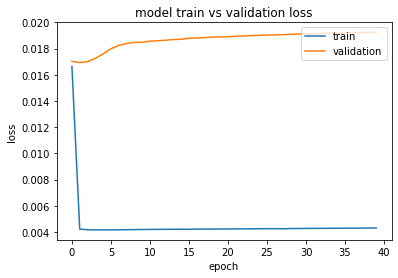

1819/1819 [==============================] - 29s 16ms/step - loss: 0.0099 - accuracy: 3.4368e-05
Test loss: 0.00985749065876007


In [28]:
#lstm model and training/testing
#lstm模型与训练和测试
import time
# Utility for our sequence model.
def get_sequence_model():
    model = keras.Sequential()
    model.add(keras.layers.LSTM(8,return_sequences=False, input_shape=(500,1)))
#     model.add(keras.layers.LSTM(16,return_sequences=False))
#     model.add(keras.layers.Dropout(0.5))
#     model.add(keras.layers.LSTM(1,return_sequences=False))
#     model.add(keras.layers.Dropout(0.3))
#     model.add(keras.layers.Dense(32,activation="relu"))
    model.add(keras.layers.Dense(1,activation="linear"))
    model.compile(loss='mse', optimizer='adam',metrics =["accuracy"])
    return model


# Utility for running experiments.
def run_experiment():
    filepath = "rnnmodel2"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )
    seq_model = get_sequence_model()
    start=time.time()
    history = seq_model.fit(
        x=scaled_X_train,
        y=scaled_y_train,
        validation_split=0.4,
        shuffle=True,
        epochs=40,
        callbacks=[checkpoint],
        batch_size=64,
    )
    stop = time.time()
    print(f"Training time: {stop - start}s")
    from matplotlib import pyplot
    # plot train and validation loss
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history['val_loss'])
    pyplot.title('model train vs validation loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper right')
    pyplot.show()

    seq_model.load_weights(filepath)
    loss,accuracy = seq_model.evaluate(scaled_X_test, scaled_y_test)
    print(f"Test loss: {loss}")
    return history, seq_model

_, sequence_model = run_experiment()

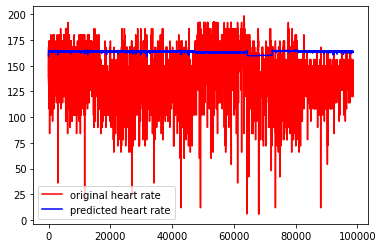

In [29]:
y_predict=sequence_model.predict(scaled_X_train)
y_predict_unscale=Yscaler.inverse_transform(y_predict)

numy=train_y.to_numpy()
ytry=numy.reshape(1, -1)
ytry=ytry[0]
b=plt.plot(ytry,'r',label='original heart rate')
a=plt.plot(y_predict_unscale,'b',label='predicted heart rate')

plt.legend()

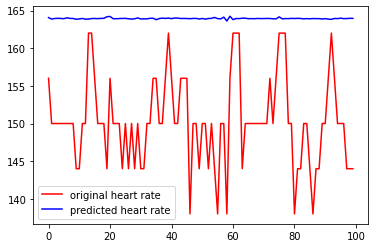

In [30]:
b=plt.plot(ytry[10000:10100],'r',label='original heart rate')
a=plt.plot(y_predict_unscale[10000:10100],'b',label='predicted heart rate')

plt.legend()

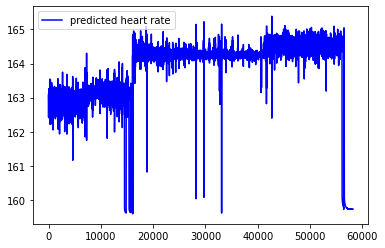

In [31]:
y_predict=sequence_model.predict(scaled_X_test)
y_predict_unscale=Yscaler.inverse_transform(y_predict)

numy=test_y.to_numpy()
ytry=numy.reshape(1, -1)
ytry=ytry[0]
a=plt.plot(y_predict_unscale,'b',label='predicted heart rate')
plt.legend()

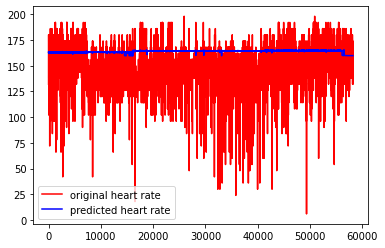

In [32]:
b=plt.plot(ytry,'r',label='original heart rate')
a=plt.plot(y_predict_unscale,'b',label='predicted heart rate')

plt.legend()

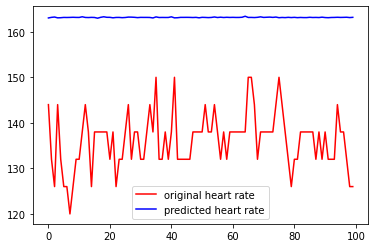

In [33]:
b=plt.plot(ytry[10000:10100],'r',label='original heart rate')
a=plt.plot(y_predict_unscale[10000:10100],'b',label='predicted heart rate')

plt.legend()

In [202]:
scaled_X_train = scaled_X_train.reshape(-1,500)
scaled_X_test = scaled_X_test.reshape(-1,500)

In [203]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

def SVR_model():
  regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
  regr.fit(scaled_X_train, scaled_y_train)
  return regr
def SVR_experiment():
  svrmodel=SVR_model()
  y_predict=svrmodel.predict(scaled_X_test)
  mse=mean_squared_error(scaled_y_test,y_predict)
  print(mse)
  return svrmodel
svrmodel=SVR_experiment()

0.0076462460645414015


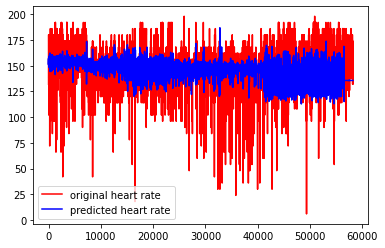

In [204]:
y_predict=svrmodel.predict(scaled_X_test)
y_predict=y_predict.reshape(-1,1)
y_predict_unscale=Yscaler.inverse_transform(y_predict)



b=plt.plot(ytry,'r',label='original heart rate')
a=plt.plot(y_predict_unscale,'b',label='predicted heart rate')

plt.legend()

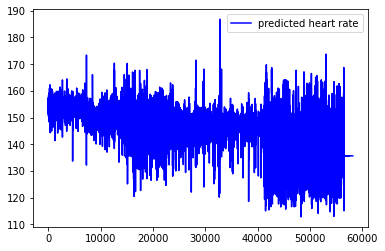

In [205]:
y_predict=svrmodel.predict(scaled_X_test)
y_predict=y_predict.reshape(-1,1)
y_predict_unscale=Yscaler.inverse_transform(y_predict)
a=plt.plot(y_predict_unscale,'b',label='predicted heart rate')
plt.legend()